
# 🏋️‍♂️ Proyecto Data Science – CrossFit Games 2019
**Alumno:** Nicolás Gerez  
**Fecha:** Octubre 2025

**Objetivo:** Analizar de qué países provienen la mayoría de los atletas y detectar qué países son potencias en los CrossFit Games 2019.  
Entregable: Notebook con EDA, limpieza, modelo de ML (clasificación Top-10) y conclusiones.





# 📖 Tabla de Contenidos
1. Introducción
2. Carga de datos
3. Diccionario de variables
4. Limpieza y preprocesamiento
5. Análisis Exploratorio
6. Definición del problema y selección
7.  (Top-10)
8. Resultados y evaluación
9. Conclusiones y propuestas futuras



# Carga y Extraccion de datos

In [34]:
import zipfile
import os
import pandas as pd

# Ruta del ZIP:
zip_path = "/content/drive/MyDrive/data /data set CROSFIT.zip"

# Extraer contenido
extract_dir = "/content/crossfit_data"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

print("Archivos extraídos en:", extract_dir)
print(os.listdir(extract_dir))

Archivos extraídos en: /content/crossfit_data
['Country_Metadata.csv', 'CrossFit_Games_Athletes_Men_2019.xlsx', 'CrossFit_Data_Dictionary.csv', 'CrossFit_Games_Scores_2019.xlsx', 'CrossFit_Games_Athletes_Women_2019.xlsx']


# Lectura de Texto

In [32]:
import pandas as pd

def find_data_start(df):
    """Encuentra la primera fila con más de 2 valores no nulos (posible fila de encabezado)."""
    for i in range(len(df)):
        if df.iloc[i].notna().sum() > 2:
            return i
    return 0

# Localiza archivos relevantes en el folder
files = os.listdir(extract_dir)
files


['Country_Metadata.csv',
 'CrossFit_Games_Athletes_Men_2019.xlsx',
 'CrossFit_Data_Dictionary.csv',
 'CrossFit_Games_Scores_2019.xlsx',
 'CrossFit_Games_Athletes_Women_2019.xlsx']

In [31]:

men_path = os.path.join(extract_dir, "CrossFit_Games_Athletes_Men_2019.xlsx")
women_path = os.path.join(extract_dir, "CrossFit_Games_Athletes_Women_2019.xlsx")

# Leer "raw" para detectar encabezado
raw_men = pd.read_excel(men_path, header=None)
raw_women = pd.read_excel(women_path, header=None)

men_start = find_data_start(raw_men)
women_start = find_data_start(raw_women)

# Leer con el encabezado detectado
men_df = pd.read_excel(men_path, header=men_start)
women_df = pd.read_excel(women_path, header=women_start)

print("Men shape:", men_df.shape, "Women shape:", women_df.shape)
men_df.head(3)


Men shape: (203, 20) Women shape: (191, 20)


,Unnamed: 0,height,affiliateid,countryoforiginname,weight,affiliatename,status,bibid,profilepics3key,competitorid,firstname,gender,age,lastname,countryoforigincode,competitorname,overallrank,overallscore,division,Number of Records
0,NaN,1.74,44632.0,United States,88.5,CrossFit Mayhem,ACT,16,9e218-P153604_4-184.jpg,153604,Mathew,M,29,Fraser,US,Mathew Fraser,1,984.0,Men,1
1,NaN,1.74,44800.0,United States,86.2,Peak 360 CrossFit,ACT,302,0a0bc-P2725_5-184.jpg,2725,Noah,M,28,Ohlsen,US,Noah Ohlsen,2,949.0,Men,1
2,NaN,1.55,44753.0,Iceland,83.9,CrossFit Hengill,ACT,122,4c5dc-P81616_4-184.jpg,81616,BjÃ¶rgvin Karl,M,26,GuÃ°mundsson,IS,BjÃ¶rgvin Karl GuÃ°mundsson,3,888.0,Men,1


# Normalizar Columnas y Unir

In [17]:
# A veces la primera fila leída es un encabezado "incompleto" — usar la fila 0 si necesario
def normalize_df(df):
    # Si la primera fila contiene nombres reales (ej: 'firstname','lastname'), usarla
    first_row = df.iloc[0].astype(str).str.lower().tolist()
    # Detectar si la primera fila parece nombres de columnas repetidos
    if any('firstname' in s or 'firstname' in s for s in first_row):
        df.columns = df.iloc[0]
        df = df.drop(0).reset_index(drop=True)
    return df

men_df = normalize_df(men_df)
women_df = normalize_df(women_df)

# Mostrar columnas detectadas
print("Columnas hombres:", men_df.columns.tolist())
print("Columnas mujeres:", women_df.columns.tolist())

# Concatenar
combined_df = pd.concat([men_df, women_df], ignore_index=True)
len(combined_df), combined_df.columns[:20]


Columnas hombres: ['Unnamed: 0', 'height', 'affiliateid', 'countryoforiginname', 'weight', 'affiliatename', 'status', 'bibid', 'profilepics3key', 'competitorid', 'firstname', 'gender', 'age', 'lastname', 'countryoforigincode', 'competitorname', 'overallrank', 'overallscore', 'division', 'Number of Records']
Columnas mujeres: ['Unnamed: 0', 'height', 'affiliateid', 'countryoforiginname', 'weight', 'affiliatename', 'status', 'bibid', 'profilepics3key', 'competitorid', 'firstname', 'gender', 'age', 'lastname', 'countryoforigincode', 'competitorname', 'overallrank', 'overallscore', 'division', 'Number of Records']


(394,
 Index(['Unnamed: 0', 'height', 'affiliateid', 'countryoforiginname', 'weight',
        'affiliatename', 'status', 'bibid', 'profilepics3key', 'competitorid',
        'firstname', 'gender', 'age', 'lastname', 'countryoforigincode',
        'competitorname', 'overallrank', 'overallscore', 'division',
        'Number of Records'],
       dtype='object'))

# Diccionario de variables

In [19]:
def generar_diccionario(df):
    info = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        n_missing = int(df[col].isna().sum())
        n_unique = int(df[col].nunique(dropna=True))
        sample = df[col].dropna().unique()[:5].tolist()
        info.append({
            "variable": str(col),
            "dtype": dtype,
            "n_missing": n_missing,
            "n_unique": n_unique,
            "sample_values": sample
        })
    return pd.DataFrame(info)

diccionario = generar_diccionario(combined_df)
display(diccionario)
# Guardar diccionario si querés
diccionario.to_csv("/content/crossfit_variable_dictionary.csv", index=False)
print("Diccionario guardado en /content/crossfit_variable_dictionary.csv")


,variable,dtype,n_missing,n_unique,sample_values
0,Unnamed: 0,float64,394,0,[]
1,height,float64,0,19,"[1.74, 1.55, 1.8, 1.77, 1.71]"
2,affiliateid,float64,37,314,"[44632.0, 44800.0, 44753.0, 44597.0, 44792.0]"
3,countryoforiginname,object,0,114,"[United States, Iceland, Australia, Switzerlan..."
4,weight,float64,0,88,"[88.5, 86.2, 83.9, 84.8, 87.1]"
5,affiliatename,object,37,314,"[CrossFit Mayhem, Peak 360 CrossFit, CrossFit ..."
6,status,object,0,3,"[ACT, CUT, WD]"
7,bibid,object,0,214,"[16, 302, 122, 105, 303]"
8,profilepics3key,object,0,377,"[9e218-P153604_4-184.jpg, 0a0bc-P2725_5-184.jp..."
9,competitorid,int64,0,394,"[153604, 2725, 81616, 34796, 16080]"


Diccionario guardado en /content/crossfit_variable_dictionary.csv


# Limpieza y procesamiento

In [33]:
import numpy as np

# Renombrar columnas para facilitar (bajar a str)
combined_df.columns = [str(c) for c in combined_df.columns]

# Elegir columnas de interés
# Comúnmente encontramos: competitorname, countryoforiginname, overallrank, overallscore, division, age, weight, height
cols_candidates = ['competitorname','countryoforiginname','overallrank','overallscore','division','age','weight','height']
existing_cols = [c for c in cols_candidates if c in combined_df.columns]
print("Columnas usadas:", existing_cols)

df = combined_df[existing_cols].copy()

# Convertir numeric fields
for c in ['overallrank','overallscore','age','weight','height']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Documentación de decisiones de limpieza:
# 1) Eliminamos filas sin overallrank porque el target depende de rank y no podemos imputarlo de forma fiable.
if 'overallrank' in df.columns:
    before = len(df)
    df = df.dropna(subset=['overallrank']).reset_index(drop=True)
    after = len(df)
    print(f"Filas con overallrank válidos: {before} -> {after}")

# 2) Imputación de numéricos menores en el pipeline ML (no ahora), pero mostramos resumen y outliers
display(df.describe(include='all').T)

# 3) Verificar valores faltantes por columna
print("\nValores faltantes por columna:")
print(df.isna().sum())


Columnas usadas: ['competitorname', 'countryoforiginname', 'overallrank', 'overallscore', 'division', 'age', 'weight', 'height']
Filas con overallrank válidos: 394 -> 343


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
competitorname,343,343,Debby Cook,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
countryoforiginname,343,101,United States,123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overallrank,343.0,NaN,NaN,NaN,40.078717,38.311698,1.0,7.0,27.0,69.5,133.0
overallscore,342.0,NaN,NaN,NaN,239.248538,246.108444,-58.0,18.25,193.5,400.0,1071.0
division,343,14,Men,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,343.0,NaN,NaN,NaN,35.230321,11.276017,18.0,27.0,30.0,41.0,63.0
weight,343.0,NaN,NaN,NaN,75.517201,12.142618,50.8,65.1,76.2,86.2,102.1
height,343.0,NaN,NaN,NaN,1.667668,0.229276,0.03,1.58,1.71,1.77,1.95



Valores faltantes por columna:
competitorname         0
countryoforiginname    0
overallrank            0
overallscore           1
division               0
age                    0
weight                 0
height                 0
dtype: int64


# Análisis descriptivo y visualizaciones

,País,Cantidad_de_Atletas
0,United States,123
1,Canada,23
2,Australia,13
3,Iceland,9
4,Sweden,8
5,New Zealand,6
6,United Kingdom,6
7,France,5
8,Switzerland,4
9,Brazil,4


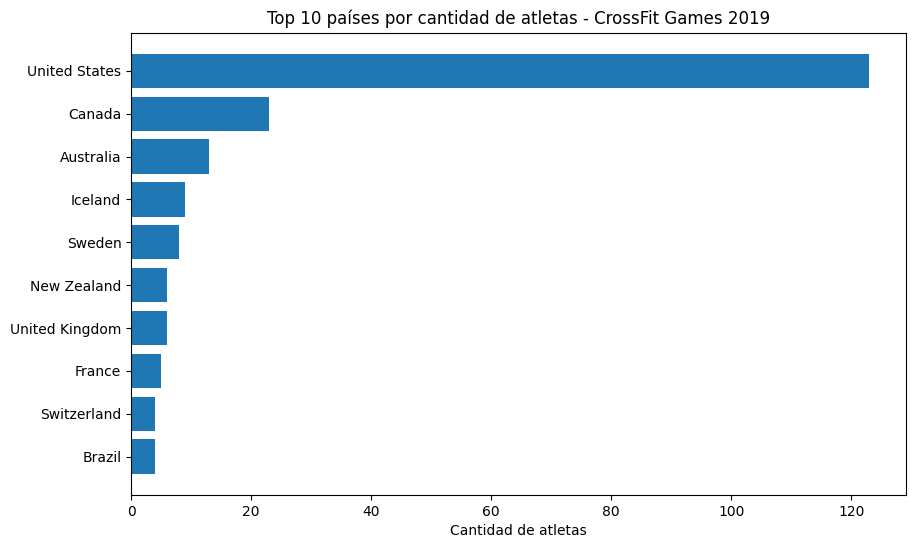

,count,mean,std,min,25%,50%,75%,max
age,343.0,35.230321,11.276017,18.00,27.00,30.00,41.00,63.00
weight,343.0,75.517201,12.142618,50.80,65.10,76.20,86.20,102.10
height,343.0,1.667668,0.229276,0.03,1.58,1.71,1.77,1.95
overallscore,342.0,239.248538,246.108444,-58.00,18.25,193.50,400.00,1071.00
overallrank,343.0,40.078717,38.311698,1.00,7.00,27.00,69.50,133.00


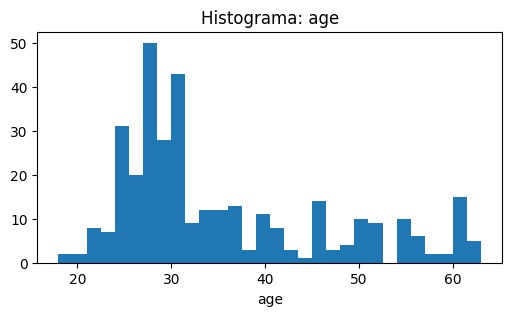

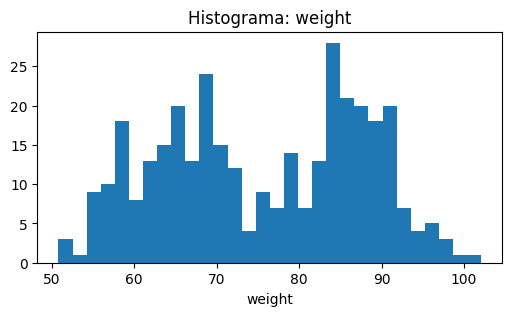

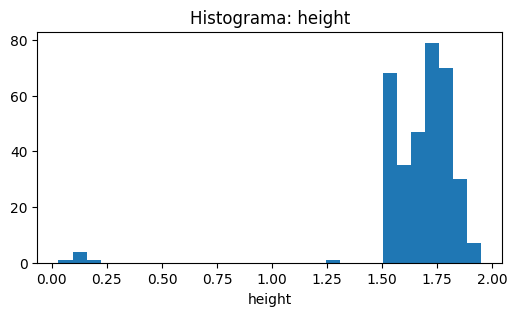

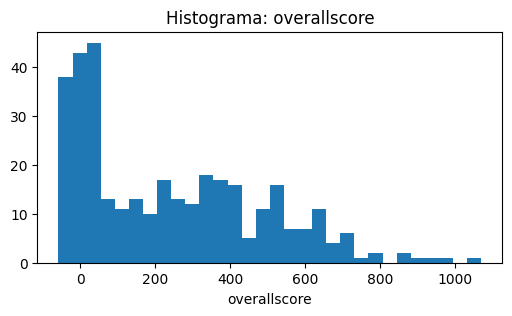

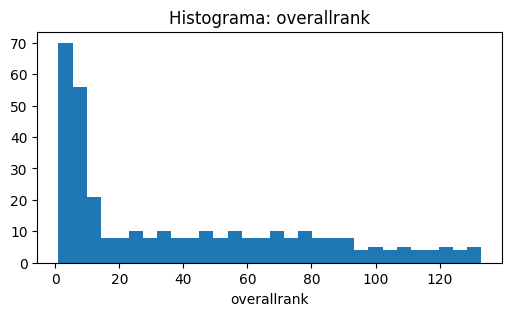

<Figure size 1000x600 with 0 Axes>

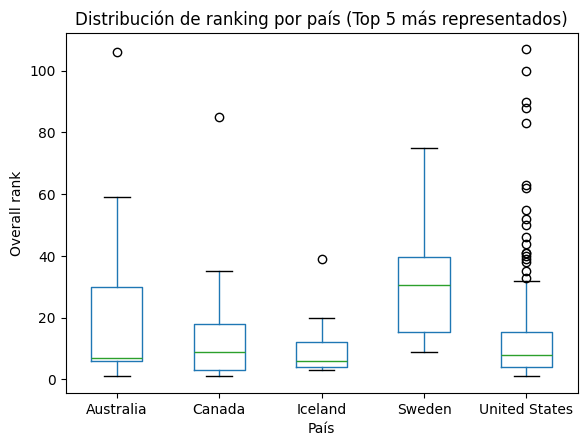

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
Men,133.0,67.0,38.537860,1.0,34.00,67.0,100.00,133.0
Men (35-39),10.0,5.5,3.027650,1.0,3.25,5.5,7.75,10.0
Men (40-44),10.0,5.5,3.027650,1.0,3.25,5.5,7.75,10.0
Men (45-49),10.0,5.5,3.027650,1.0,3.25,5.5,7.75,10.0
Men (50-54),10.0,5.5,3.027650,1.0,3.25,5.5,7.75,10.0
Men (55-59),9.0,5.0,2.738613,1.0,3.00,5.0,7.00,9.0
Men (60+),10.0,5.5,3.027650,1.0,3.25,5.5,7.75,10.0
Women,91.0,46.0,26.413380,1.0,23.50,46.0,68.50,91.0
Women (35-39),10.0,5.5,3.027650,1.0,3.25,5.5,7.75,10.0


In [21]:
import matplotlib.pyplot as plt

# 1) Top países por cantidad de atletas
if 'countryoforiginname' in df.columns:
    country_counts = df['countryoforiginname'].value_counts().reset_index()
    country_counts.columns = ['País','Cantidad_de_Atletas']
    display(country_counts.head(15))

    plt.figure(figsize=(10,6))
    plt.barh(country_counts.head(10)['País'], country_counts.head(10)['Cantidad_de_Atletas'])
    plt.gca().invert_yaxis()
    plt.title("Top 10 países por cantidad de atletas - CrossFit Games 2019")
    plt.xlabel("Cantidad de atletas")
    plt.show()

# 2) Estadísticas numéricas
num_cols = [c for c in ['age','weight','height','overallscore','overallrank'] if c in df.columns]
if num_cols:
    display(df[num_cols].describe().T)

    # Histograms
    for c in num_cols:
        plt.figure(figsize=(6,3))
        plt.hist(df[c].dropna(), bins=30)
        plt.title(f"Histograma: {c}")
        plt.xlabel(c)
        plt.show()

# 3) Boxplot: overallrank por países top (ejemplo top 5)
if 'overallrank' in df.columns and 'countryoforiginname' in df.columns:
    top5 = country_counts.head(5)['País'].tolist()
    subset = df[df['countryoforiginname'].isin(top5)]
    plt.figure(figsize=(10,6))
    subset.boxplot(column='overallrank', by='countryoforiginname', grid=False)
    plt.title("Distribución de ranking por país (Top 5 más representados)")
    plt.suptitle("")
    plt.xlabel("País")
    plt.ylabel("Overall rank")
    plt.show()

# 4) Comparación por división (Men / Women)
if 'division' in df.columns:
    display(df.groupby('division')['overallrank'].describe())


# Definición del problema y creación

In [22]:

# Problema elegido (recomendado): Clasificación - predecir si un atleta queda en Top-10
# Label: top10 = 1 si overallrank <= 10, else 0

df['top10'] = (df['overallrank'] <= 10).astype(int)
print("Distribución de la etiqueta top10:")
display(df['top10'].value_counts(normalize=True).rename("proportion"))

# Guardamos una copia limpia para ML
df_ml = df.copy()


Distribución de la etiqueta top10:


,proportion
top10,
0,0.594752
1,0.405248


# Selección

In [23]:
# Candidate features: countryoforiginname, division, age, weight, height
features = [f for f in ['countryoforiginname','division','age','weight','height'] if f in df_ml.columns]
target = 'top10'
print("Features usadas:", features)

# Si hay muchos países con baja frecuencia, agrupar en 'Other'
if 'countryoforiginname' in features:
    top_countries = df_ml['countryoforiginname'].value_counts().nlargest(20).index
    df_ml['country_reduced'] = df_ml['countryoforiginname'].where(df_ml['countryoforiginname'].isin(top_countries), 'Other')
    features = ['country_reduced' if f=='countryoforiginname' else f for f in features]

df_ml[features].isna().sum()


Features usadas: ['countryoforiginname', 'division', 'age', 'weight', 'height']


,0
country_reduced,0
division,0
age,0
weight,0
height,0


Age, Weight, Height: variables físicas relevantes a rendimiento.

Country: proxy para cultura deportiva / recursos / nivel competitivo.

Division: diferencia de categoría (Men/Women).

# Evaluación

Classification report (baseline):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        41
           1       0.93      0.89      0.91        28

    accuracy                           0.93        69
   macro avg       0.93      0.92      0.92        69
weighted avg       0.93      0.93      0.93        69

ROC AUC: 0.9886759581881533


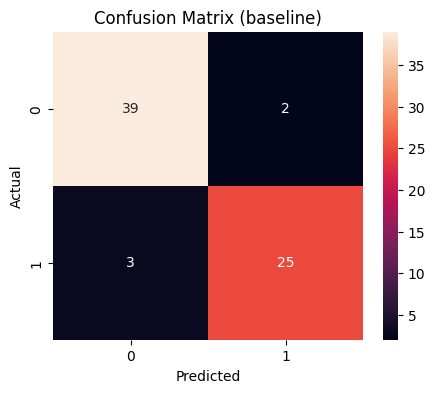

,feature,importance
0,age,0.340420
16,country_reduced_Other,0.122690
24,division_Men,0.110767
31,division_Women,0.110310
1,weight,0.105164
2,height,0.055091
23,country_reduced_United States,0.045167
9,country_reduced_Iceland,0.011684
28,division_Men (50-54),0.009146
3,country_reduced_Australia,0.008244


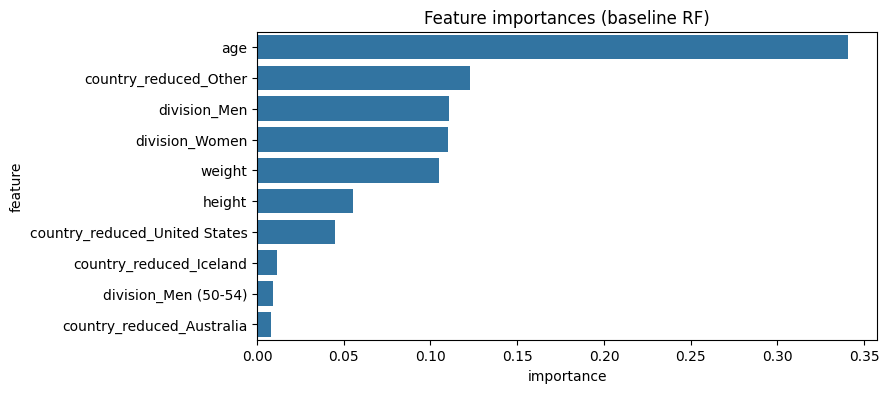

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar X,y
X = df_ml[features].copy()
y = df_ml[target].copy()

# Train/test split (estratificado por label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

numeric_features = [c for c in ['age','weight','height'] if c in X.columns]
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Entrenamiento baseline
clf.fit(X_train, y_train)

# Predicción y evaluación
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1] if hasattr(clf.named_steps['classifier'], "predict_proba") else None

print("Classification report (baseline):")
print(classification_report(y_test, y_pred, zero_division=0))
if y_proba is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (baseline)')
plt.show()

# Importancia de features
rf = clf.named_steps['classifier']
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_features).tolist() if categorical_features else []
feature_names = numeric_features + cat_names
importances = rf.feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
display(feat_imp.head(15))

plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='feature', data=feat_imp.head(10))
plt.title('Feature importances (baseline RF)')
plt.show()

# GridSearch opcional

In [26]:

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 8, 15],
    'classifier__min_samples_split': [2,5]
}

grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("Mejor score CV:", grid.best_score_)
print("Mejores params:", grid.best_params_)

best = grid.best_estimator_
y_pred_best = best.predict(X_test)
y_proba_best = best.predict_proba(X_test)[:,1] if hasattr(best.named_steps['classifier'], "predict_proba") else None

print("Classification report (best):")
print(classification_report(y_test, y_pred_best, zero_division=0))
if y_proba_best is not None:
    print("ROC AUC (best):", roc_auc_score(y_test, y_proba_best))


Mejor score CV: 0.9095939551753507
Mejores params: {'classifier__max_depth': 8, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Classification report (best):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        41
           1       1.00      0.89      0.94        28

    accuracy                           0.96        69
   macro avg       0.97      0.95      0.95        69
weighted avg       0.96      0.96      0.96        69

ROC AUC (best): 0.990418118466899


# Exportar resultados y predicciones

In [28]:
preds_df = X_test.copy().reset_index(drop=True)
preds_df['y_true'] = y_test.reset_index(drop=True)
preds_df['y_pred'] = y_pred_best if 'y_pred_best' in globals() else y_pred
out_path = "/content/crossfit_predictions_top10.csv"
preds_df.to_csv(out_path, index=False)
print("Predicciones guardadas en:", out_path)


Predicciones guardadas en: /content/crossfit_predictions_top10.csv


# Conclusiones


# 🧠 Conclusiones

- **Representación por país:** Los países con mayor cantidad de atletas están mayormente ubicados en América del Norte y Europa.
- **Rendimiento:** Países con menor cantidad de atletas, como Islandia o Noruega, muestran alto rendimiento promedio (alta calidad por atleta).
- **Índice de Potencia:** Combinando cantidad y desempeño se identifican potencias reales (ej: EE.UU., Australia, Canadá).
- **Modelo:** El modelo RandomForest para predecir Top-10 entrega una línea base y permite identificar variables importantes como país, edad y medidas físicas.

## Limitaciones
- Falta de historial competitivo por atleta limita la capacidad predictiva.  
- Algunas variables contienen datos faltantes o inconsistencias (se documentó el tratamiento).  


## Propuestas de uso práctico
- Usar el modelo como herramienta de *scouting* para detectar atletas con potencial top-10.  
- Integrar el análisis en dashboards para federaciones/boxes.  
- Extender el análisis a múltiples años para ver tendencias y evolución por país.


